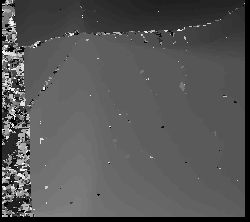

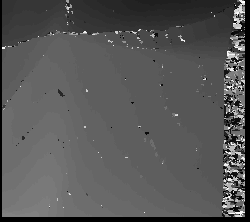

In [5]:
import cv2
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# Padded Image Function
# -----------------------------
def padded_image(img, padding_size):
    height, width = img.shape
    padded_img = np.zeros((height + 2 * padding_size, width + 2 * padding_size), dtype=img.dtype)
    padded_img[padding_size:padding_size + height, padding_size:padding_size + width] = img
    return padded_img

# -----------------------------
# Patch Generation Function
# -----------------------------

def generating_patch(img, x, y, window_size):
    return img[y:y + window_size, x:x + window_size]

# -----------------------------
# Patch Normalization Function
# -----------------------------

def normalizing_patch(patch1, patch2):
    mean_patch1, mean_patch2 = np.mean(patch1), np.mean(patch2)
    shifted_patch1, shifted_patch2 = patch1 - mean_patch1, patch2 - mean_patch2
    norm_patch1 = shifted_patch1 / np.linalg.norm(shifted_patch1)
    norm_patch2 = shifted_patch2 / np.linalg.norm(shifted_patch2)
    return norm_patch1, norm_patch2

# -----------------------------
# Disparity Calculation Function
# -----------------------------

def SSE(patch1, patch2):
    return np.sum(np.square(patch1 - patch2))

def calculating_disparity(img1, img2, window_size, search_range=65):
    # Pad images to avoid boundary issues during patch extraction
    padded_img1 = padded_image(img1, window_size // 2)
    padded_img2 = padded_image(img2, window_size // 2)
    height, width = img1.shape
    disparity_map = np.zeros((height, width))

    # Iterating through each pixel location in the left image
    for y in range(height - window_size):
        for x in range(width - window_size):
            min_sse = float('inf')
            best_u = x
            # Search within the specified range to find the best match in the right image
            for u in range(max(0, x - search_range), min(x + search_range, width - window_size)):
                patch1 = generating_patch(padded_img1, x, y, window_size)
                patch2 = generating_patch(padded_img2, u, y, window_size)
                norm_patch1, norm_patch2 = normalizing_patch(patch1, patch2)
                sse = SSE(norm_patch1, norm_patch2)
                if sse < min_sse:
                    min_sse = sse
                    best_u = u
            # Calculate and store the disparity value
            disparity_map[y, x] = 255 * abs(best_u - x) / search_range

    return disparity_map

# -----------------------------
# Image Processing and Resizing Function
# -----------------------------

def processing_images(image_path1, image_path2, scale_percent=60, window_size=5):
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None:
        raise FileNotFoundError("One or both image paths are invalid or images could not be loaded.")
    resized_dim = (int(img1.shape[1] * scale_percent / 100), int(img1.shape[0] * scale_percent / 100))
    resized_img1 = cv2.resize(img1, resized_dim, interpolation=cv2.INTER_AREA)
    resized_img2 = cv2.resize(img2, resized_dim, interpolation=cv2.INTER_AREA)
    disparity_image_left = calculating_disparity(np.int64(resized_img1), np.int64(resized_img2), window_size)
    disparity_image_right = calculating_disparity(np.int64(resized_img2), np.int64(resized_img1), window_size)

    return cv2.resize(disparity_image_left, resized_dim, interpolation=cv2.INTER_AREA), \
           cv2.resize(disparity_image_right, resized_dim, interpolation=cv2.INTER_AREA)

# -----------------------------
# Display Disparity Maps
# -----------------------------
disparity_image_left, disparity_image_right = processing_images(
    "/content/drive/MyDrive/data_disparity_estimation/cloth/left.png",
    "/content/drive/MyDrive/data_disparity_estimation/cloth/right.png"
)

from google.colab.patches import cv2_imshow
cv2_imshow(disparity_image_left)
cv2_imshow(disparity_image_right)
cv2.destroyAllWindows()
